## Imports

In [15]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib
from sklearn.svm import SVC
import random
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from tqdm import tqdm_notebook
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from mlxtend.classifier import StackingClassifier
from sklearn.feature_selection import RFE
from matplotlib import pyplot as plt 
import numpy as np
import neptune.new as neptune
from imblearn.over_sampling import SMOTE
import eli5
from eli5.sklearn import PermutationImportance
%matplotlib inline
pd.set_option('display.max_columns', None)
RANDOM_STATE=1

In [16]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

## Feature engineering

In [17]:
features = [c for c in train.columns if c not in ['id', 'target']]
for df in [test, train]:
    df['sum'] = df[features].sum(axis=1)  
    df['min'] = df[features].min(axis=1)
    df['max'] = df[features].max(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['std'] = df[features].std(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurtosis(axis=1)
    df['med'] = df[features].median(axis=1)

Distribution of new features, grouped by value of corresponding target values:

In [18]:
def plot_new_feature_distribution(df1: pd.DataFrame, df2: pd.DataFrame, label1: str, label2: str, features: str) -> pd.DataFrame:
    """
    Returns ploted features grouped by target.

    Args:
        df1/2: dataframe,
        label1/2: labels for targets,
        features: features to plot

    Returns:
        plot
    """

    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
        plt.legend()
    plt.show();

<Figure size 432x288 with 0 Axes>

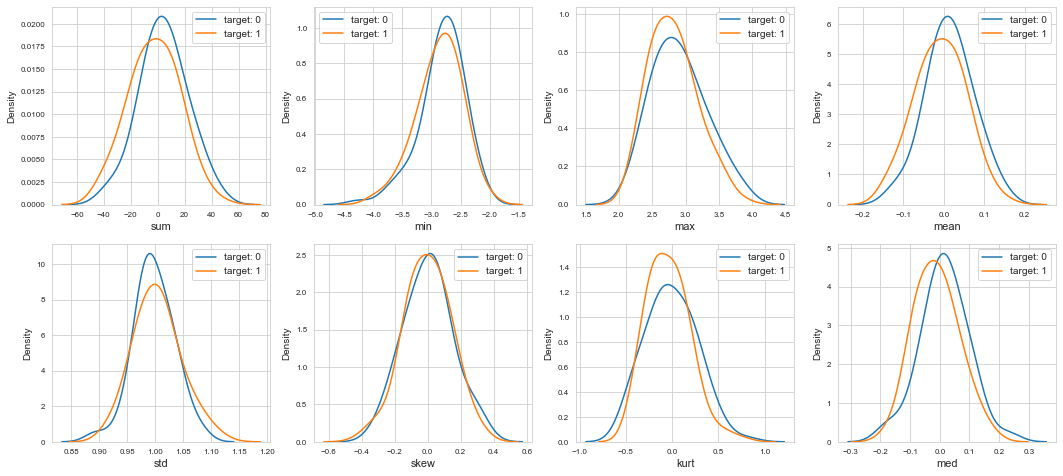

In [19]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[302:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

Distribution of new features values for train and test:

<Figure size 432x288 with 0 Axes>

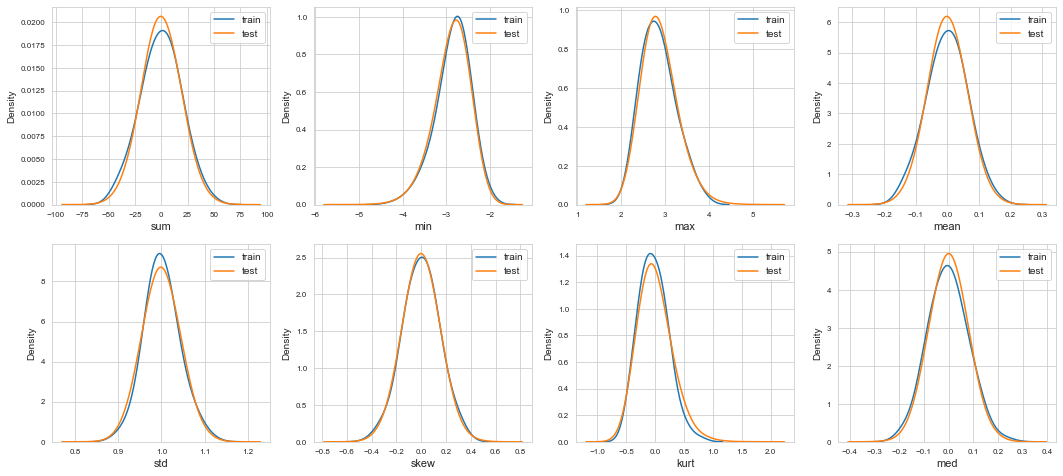

In [20]:
features = train.columns.values[302:]
plot_new_feature_distribution(train, test, 'train', 'test', features)

Checking how many features there are now:

In [21]:
print('Train and test columns: {} {}'.format(len(train.columns), len(test.columns)))

Train and test columns: 310 309


### Applying noise

In [22]:
def apply_noise(data: pd.DataFrame, noise_level: int) -> pd.DataFrame:
    """
    Return augmented data with added noise.

    Args:
        data: dataframe,
        noise_level: chosen noise level.

    Returns:
        augmented dataframe.
    """
        
    idxt = data[['id', 'target']]
    features = data.columns.values[2:]
    appended_data = []
    for feature in features:
        signal = data[feature]
        noise_factor = (np.abs(signal)).mean() * noise_level
        noise =  np.random.normal(0, noise_level, signal.shape)
        jittered = signal + noise
        appended_data.append(pd.DataFrame(jittered))
    appended_data = pd.concat(appended_data, axis=1)
    data_jittered = pd.concat([idxt, pd.DataFrame(appended_data)], axis=1)
    return data_jittered

In [437]:
noise_train = []
for i in tqdm_notebook(range(0,2)):
    t = apply_noise(train, noise_level = i * 0.025)
    noise_train.append(t)
noise_train = pd.concat(noise_train, axis = 0)

  0%|          | 0/2 [00:00<?, ?it/s]

In [438]:
print("Train shape with additional rows with noise added:",noise_train.shape)
train = noise_train

Train shape with additional rows with noise added: (500, 310)


### Balancing data

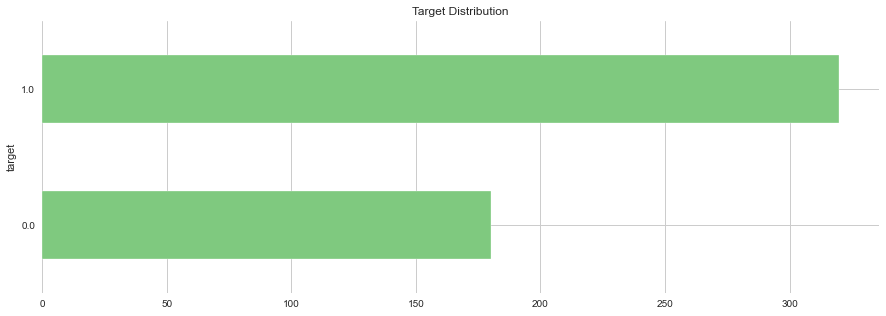

In [439]:
train.groupby('target').count()['id'].plot(kind='barh', title='Target Distribution', figsize=(15, 5), cmap="Accent")
plt.show()

In [440]:
target = train['target']
test = test.drop(['id'], axis=1)

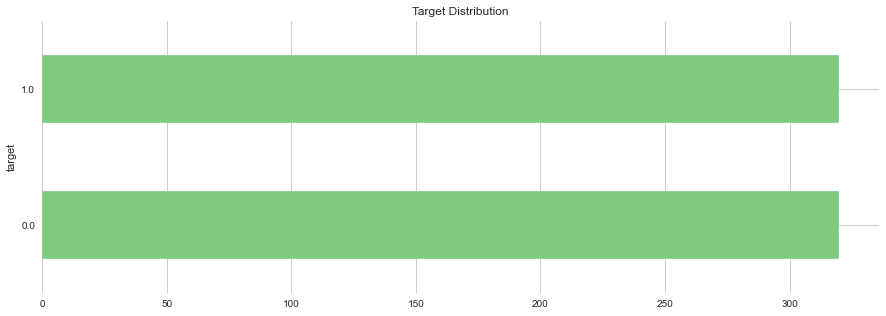

In [441]:
sm = SMOTE(random_state=RANDOM_STATE, k_neighbors=3, n_jobs = 5)
train, target = sm.fit_resample(train, target)
train.groupby('target').count()['id'].plot(kind='barh', title='Target Distribution', figsize=(15, 5), cmap="Accent")
plt.show()

## Scaling and spliting

In [446]:
sc=RobustScaler()
labels=sc.fit_transform(labels)
test=sc.transform(test)

In [447]:
X_train, X_test, y_train, y_test = train_test_split(
    labels, target, test_size=0.3, random_state=RANDOM_STATE)

# Models

## Random forest classifier

#### Baseline model

In [448]:
params = {
        'n_estimators': 4500,
        'min_samples_split':5, 
        'min_samples_leaf':3,
        'min_weight_fraction_leaf':0.2,
        'max_depth':5, 
        'min_impurity_decrease':0,
        'max_leaf_nodes':50,
        'random_state':RANDOM_STATE
        }

In [449]:
%%time

rfc = RandomForestClassifier(**params)

rfc.fit(X_train, y_train)
y_train_pred = rfc.predict_proba(X_train)
y_test_pred = rfc.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Train f1:0.9605568445475638 | Test f1:0.877005347593583
Wall time: 7.87 s


In [377]:
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': 50,
 'max_samples': None,
 'min_impurity_decrease': 0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.2,
 'n_estimators': 4500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


#### AUC-ROC

In [378]:
fpr, tpr, thresh = roc_curve(y_test, y_test_pred[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
auc_score = roc_auc_score(y_test, y_test_pred[:,1])
print(auc_score)

0.9758695652173913


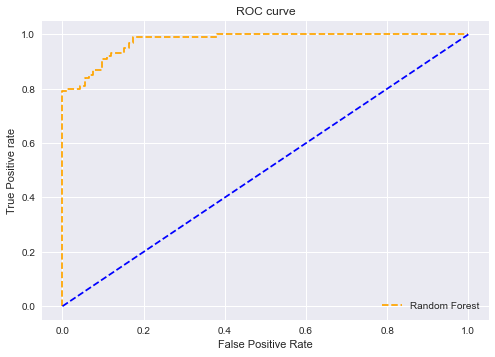

In [379]:
plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Logs

In [380]:
run = neptune.init(project='mila1/kaggle-335',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkMzdkYWQxNi1iYjlmLTRlODktOTZiZi1mYjY0MjkwM2FkYTYifQ==')
run["parameters"] = params
run["sys/tags"].add(["random"])
run["train/f1"] = train_f1
run["test/f1"] = test_f1
run.stop()

https://app.neptune.ai/mila1/kaggle-335/e/KAG-71
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 27 operations to synchronize with Neptune. Do not kill this process.


All 27 operations synced, thanks for waiting!


#### Hyperparameter optimization

In [450]:
skf = StratifiedKFold(n_splits=4, shuffle = True, random_state = RANDOM_STATE)

In [451]:
%%time

random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
                 }

random_search = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                                 n_iter = 100, cv = skf.split(X_train,y_train), 
                                 verbose=2, random_state=RANDOM_STATE, n_jobs = -1)
random_search.fit(X_train, y_train)
print('Best score: {}'.format(random_search.best_score_))
print('Best parameters: {}'.format(random_search.best_params_))

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best score: 0.8638392857142857
Best parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}
Wall time: 3min 25s


#### RFE

In [452]:
%%time

best_params_rfc = random_search.best_params_
rfc = RandomForestClassifier(**best_params_rfc)
rfc.fit(X_train, y_train)

selector = RFE(estimator=rfc, 
          n_features_to_select=100, step=10)
selector.fit(X_train, y_train)

y_train_pred = selector.predict_proba(X_train)
y_test_pred = selector.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Train f1:1.0 | Test f1:0.98
Wall time: 1min 8s


#### Submission

In [453]:
rfc_pred = selector.predict_proba(test)
output = pd.DataFrame({'Id': sample['id'],
                       'Target': rfc_pred[:,1]})
output.to_csv('RandomForestClassifier.csv', index=False)
output.head()

,Id,Target
0,250,0.578
1,251,0.633
2,252,0.462
3,253,0.743
4,254,0.570


## Logistic regression

#### Baseline model

In [3]:
params = {
    'C':0.1,  
    'fit_intercept':True, 
    'intercept_scaling':1, 
    'max_iter':1000, 
    'solver':'liblinear', 
    'random_state':RANDOM_STATE
}

In [455]:
%%time

log=LogisticRegression(**params)
log.fit(X_train, y_train)
y_train_pred = log.predict_proba(X_train)
y_test_pred = log.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Train f1:1.0 | Test f1:0.9690721649484536
Wall time: 23.9 ms


In [456]:
print('Parameters currently in use:\n')
pprint(log.get_params())

Parameters currently in use:

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


#### AUC-ROC

In [457]:
fpr, tpr, thresh = roc_curve(y_test, y_test_pred[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test, y_test_pred[:,1])
print(auc_score1)

0.9869565217391304


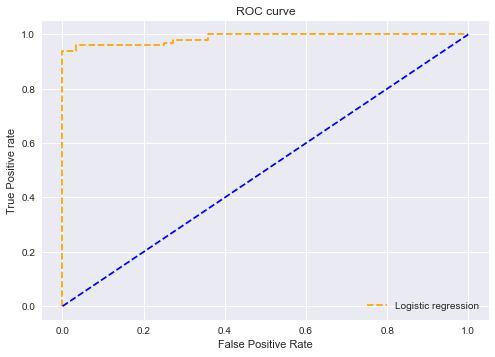

In [458]:
plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Logs

In [367]:
run = neptune.init(project='mila1/kaggle-335',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkMzdkYWQxNi1iYjlmLTRlODktOTZiZi1mYjY0MjkwM2FkYTYifQ==')
run["parameters"] = params
run["sys/tags"].add(["logreg"])
run["train/f1"] = train_f1
run["test/f1"] = test_f1
run.stop()

https://app.neptune.ai/mila1/kaggle-335/e/KAG-70
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 27 operations to synchronize with Neptune. Do not kill this process.


All 27 operations synced, thanks for waiting!


#### Hyperparameter optimisation

In [459]:
skf = StratifiedKFold(n_splits=4, shuffle = True, random_state = RANDOM_STATE)

In [460]:
%%time

random_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100,800,100))
                 }

random_search = RandomizedSearchCV(estimator = log, param_distributions = random_grid, 
                                 n_iter = 100, cv = skf.split(X_train,y_train), 
                                 verbose=2, random_state=RANDOM_STATE, n_jobs = -1)
random_search.fit(X_train, y_train)
print('Best score: {}'.format(random_search.best_score_))
print('Best parameters: {}'.format(random_search.best_params_))

Fitting 4 folds for each of 98 candidates, totalling 392 fits
Best score: 0.8995535714285714
Best parameters: {'penalty': 'l2', 'max_iter': 100, 'C': 10}
Wall time: 2.65 s


#### RFE

In [465]:
%%time

best_params_log = random_search.best_params_
log = LogisticRegression(**best_params_log)
log.fit(X_train, y_train)

selector = RFE(estimator=log, 
          n_features_to_select=10, step=100)
selector.fit(X_train, y_train)

y_train_pred = selector.predict_proba(X_train)
y_test_pred = selector.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Train f1:0.8146453089244851 | Test f1:0.74
Wall time: 58.8 ms


#### Submission

In [466]:
log_preds = selector.predict_proba(test)
output = pd.DataFrame({'Id': sample['id'],
                       'Target': log_preds[:,1]})
output.to_csv('LogisticRegression.csv', index=False)
output.head()

,Id,Target
0,250,0.960578
1,251,0.767870
2,252,0.204105
3,253,0.774905
4,254,0.490086


## SVC

#### Baseline model

In [467]:
params = {
    'probability':True, 
    'gamma':'scale', 
    'C': 1,
    'degree':100,
    'random_state':RANDOM_STATE
}

In [468]:
%time

svc = SVC(**params)
svc.fit(X_train, y_train)
y_train_pred = svc.predict_proba(X_train)
y_test_pred = svc.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Wall time: 0 ns
Train f1:1.0 | Test f1:0.98


In [469]:
print('Parameters currently in use:\n')
pprint(svc.get_params())

Parameters currently in use:

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 100,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


#### AUC-ROC

In [470]:
fpr, tpr, thresh = roc_curve(y_test, y_test_pred[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_test, y_test_pred[:,1])
print(auc_score1)

0.9982608695652174


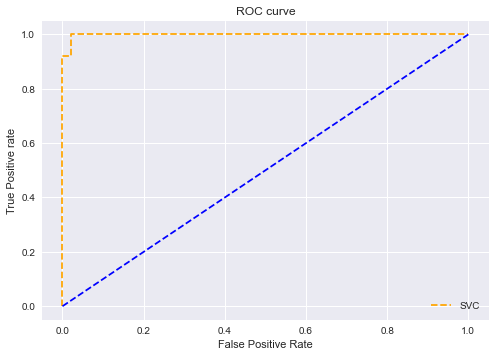

In [471]:
plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle='--',color='orange', label='SVC')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Logs

In [116]:
run = neptune.init(project='mila1/kaggle-335',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkMzdkYWQxNi1iYjlmLTRlODktOTZiZi1mYjY0MjkwM2FkYTYifQ==')
run["parameters"] = params
run["sys/tags"].add(["svc"])
run["train/f1"] = train_f1
run["test/f1"] = test_f1
run.stop()

https://app.neptune.ai/mila1/kaggle-335/e/KAG-56
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 19 operations to synchronize with Neptune. Do not kill this process.


All 19 operations synced, thanks for waiting!


#### Hyperparameter tuning

In [472]:
skf = StratifiedKFold(n_splits=4, shuffle = True, random_state = RANDOM_STATE)

In [473]:
%time

parameter_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'kernel': ['linear', 'poly', 'rbf'],
                 }

random_search_svc = RandomizedSearchCV(estimator = svc, param_distributions = parameter_grid, 
                                 n_iter = 100, cv = skf.split(X_train,y_train), 
                                 verbose=2, random_state=RANDOM_STATE, n_jobs = -1)
random_search_svc.fit(X_train, y_train)
print('Best score: {}'.format(random_search_svc.best_score_))
print('Best parameters: {}'.format(random_search_svc.best_params_))

Wall time: 0 ns
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best score: 0.9129464285714286
Best parameters: {'kernel': 'rbf', 'C': 1.0}


In [474]:
%time

svc = SVC(probability=True, gamma='scale', C= 1.0, kernel= 'rbf')
svc.fit(X_train, y_train)

y_train_pred = svc.predict_proba(X_train)
y_test_pred = svc.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Wall time: 0 ns
Train f1:1.0 | Test f1:0.98


#### Submission

In [475]:
svc_preds = svc.predict_proba(test)
output = pd.DataFrame({'Id': sample['id'],
                       'Target': svc_preds[:,1]})
output.to_csv('LogisticRegression.csv', index=False)
output.head()

,Id,Target
0,250,0.572059
1,251,0.722688
2,252,0.490229
3,253,0.960422
4,254,0.647841


### Cross Validation

In [487]:
results = []
names = []

for model_type in [
    RandomForestClassifier, 
    LogisticRegression,
    SVC
                  ]:
    clf = model_type()
    cv = ShuffleSplit(n_splits=100, test_size=0.25, random_state=RANDOM_STATE)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='roc_auc')
    results.append(scores)
    names.append(model_type)
    print("{} Accuracy: {} (+/- {})".format(model_type.__name__, scores.mean(), scores.std() * 2))

RandomForestClassifier Accuracy: 0.9780140178371944 (+/- 0.025118106050112735)
LogisticRegression Accuracy: 0.9694273877281786 (+/- 0.035504426406530384)
SVC Accuracy: 0.9835522916049202 (+/- 0.0180977082694803)


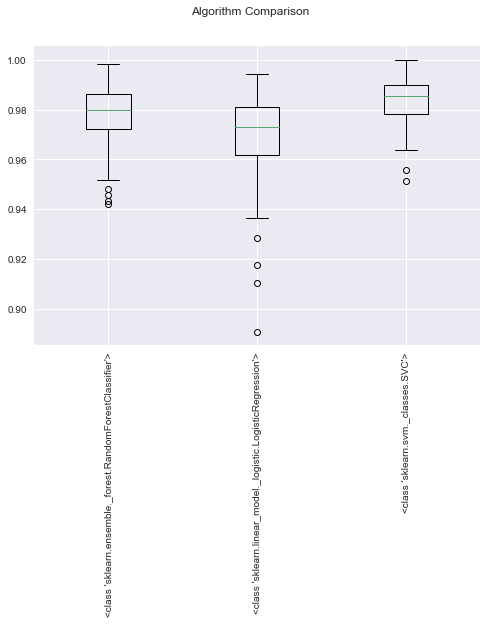

In [489]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=90)
plt.show()

### Stacking

In [482]:
m = StackingClassifier(
    classifiers=[
        LogisticRegression(),
        RandomForestClassifier()
        #SVC(probability=True)
    ],
    use_probas=True,
    meta_classifier=LogisticRegression()
)

_ = m.fit(X_train, y_train)

In [483]:
y_train_pred = m.predict_proba(X_train)
y_test_pred = m.predict_proba(X_test)

train_f1 = f1_score(y_train, y_train_pred.argmax(axis=1))
test_f1 = f1_score(y_test, y_test_pred.argmax(axis=1))
print(f"Train f1:{train_f1} | Test f1:{test_f1}")

Train f1:1.0 | Test f1:0.9690721649484536


In [484]:
preds = m.predict_proba(test)
output = pd.DataFrame({'Id': sample['id'],
                       'Target': preds[:,1]})
output.to_csv('stacked.csv', index=False)
output.head()

,Id,Target
0,250,0.217152
1,251,0.130826
2,252,0.731307
3,253,0.970551
4,254,0.757234


Summary:
* Best performing model was logistic regression (highest public and private scores)
* Lowest performing model was SVC which was also not included into stacked model.
* Stacked model did not improve overal score.